In [2]:
import h5py
import numpy as np

/home/wzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def getName(dataset, index):
    names = dataset["digitStruct"]["name"]
    return ''.join([chr(c[0]) for c in dataset[names[index][0]].value])

In [4]:
test_dataset = h5py.File("data/test/digitStruct.mat", "r")

In [5]:
from PIL import Image

Image.open("data/test/" + getName(test_dataset, 100))

In [6]:
def bboxHelper(dataset, attr):
    if (len(attr) > 1):
        attr = [dataset[attr.value[j].item()].value[0][0] for j in range(len(attr))]
    else:
        attr = [attr.value[0][0]]
        
    return attr

def getBbox(dataset, index):
    item = dataset[dataset["digitStruct"]["bbox"][index].item()]
    
    return {
        "height": bboxHelper(dataset, item["height"]),
        "label": bboxHelper(dataset, item["label"]),
        "left": bboxHelper(dataset, item["left"]),
        "top": bboxHelper(dataset, item["top"]),
        "width": bboxHelper(dataset, item["width"]),
    }

In [7]:
getBbox(test_dataset, 1000)  # every digit has a box


{'height': [19.0, 19.0, 19.0],
 'label': [1.0, 1.0, 9.0],
 'left': [66.0, 72.0, 79.0],
 'top': [28.0, 29.0, 29.0],
 'width': [10.0, 9.0, 13.0]}

In [8]:
def getWholeBox(dataset, index, im):
    bbox = getBbox(dataset, index)
    
    im_left = min(bbox["left"])
    im_top = min(bbox["top"])
    im_height = max(bbox["top"]) + max(bbox["height"]) - im_top
    im_width = max(bbox["left"]) + max(bbox["width"]) - im_left
    
    im_top = im_top - im_height * 0.05 # a bit higher
    im_left = im_left - im_width * 0.05 # a bit wider
    im_bottom = min(im.size[1], im_top + im_height * 1.05)
    im_right = min(im.size[0], im_left + im_width * 1.05)
    
    return {
        "label": bbox["label"],
        "left": im_left,
        "top": im_top,
        "right": im_right,
        "bottom": im_bottom
    }

In [9]:
im = Image.open("data/test/" + getName(test_dataset, 1000))
getWholeBox(test_dataset, 100, im)

{'bottom': 16.0, 'label': [1.0, 2.0], 'left': 20.2, 'right': 37.0, 'top': 2.35}

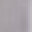

In [10]:
box = getWholeBox(test_dataset, 100, im)

im = im.crop((box["left"], box["top"], box["right"], box["bottom"]))
im.resize((32,32))

In [11]:
from keras.utils import np_utils

test_count = test_dataset["digitStruct"]["name"].shape[0]

X_test = np.ndarray(shape=(test_count, 32, 32, 3), dtype='float32')
y = {
    0: np.zeros(test_count),
    1: np.ones(test_count) * 10,
    2: np.ones(test_count) * 10,
    3: np.ones(test_count) * 10,
    4: np.ones(test_count) * 10,
    5: np.ones(test_count) * 10
}

for i in range(test_count):
    im = Image.open("data/test/" + getName(test_dataset, i))
    box = getWholeBox(test_dataset, i, im)
    if len(box["label"]) > 3:
        continue
    im = im.crop((box["left"], box["top"], box["right"], box["bottom"])).resize((32, 32))

    X_test[i, :, :, :] = np.array(im.resize((32, 32)), dtype='float32')

    labels = box["label"]

    y[0][i] = len(labels)

    for j in range(0, 3):
        if j < len(labels):
            if labels[j] == 10:
                y[j + 1][i] = 10
            else:
                y[j + 1][i] = int(labels[j])
        else:
            y[j + 1][i] = 10

    # if i % 500 == 0:
    #     print(i, len(y[0]))

y_test = [
    np_utils.to_categorical(y[0]),
    np_utils.to_categorical(y[1]),
    np_utils.to_categorical(y[2]),
    np_utils.to_categorical(y[3])
]


Using TensorFlow backend.


In [12]:
# %load layers.py
from keras import backend as K
from keras.engine.topology import Layer

if K.backend() == 'tensorflow':
    import tensorflow as tf

    def K_meshgrid(x, y):
        return tf.meshgrid(x, y)

    def K_linspace(start, stop, num):
        return tf.linspace(start, stop, num)

else:
    raise Exception("Only 'tensorflow' is supported as backend")


class BilinearInterpolation(Layer):
    """Performs bilinear interpolation as a keras layer
    References
    ----------
    [1]  Spatial Transformer Networks, Max Jaderberg, et al.
    [2]  https://github.com/skaae/transformer_network
    [3]  https://github.com/EderSantana/seya
    """

    def __init__(self, output_size, **kwargs):
        self.output_size = output_size
        super(BilinearInterpolation, self).__init__(**kwargs)

    def compute_output_shape(self, input_shapes):
        height, width = self.output_size
        num_channels = input_shapes[0][-1]
        return (None, height, width, num_channels)

    def call(self, tensors, mask=None):
        X, transformation = tensors
        output = self._transform(X, transformation, self.output_size)
        return output

    def _interpolate(self, image, sampled_grids, output_size):

        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d
        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = K_linspace(-1., 1., width)
        y_linspace = K_linspace(-1., 1., height)
        x_coordinates, y_coordinates = K_meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))
        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, affine_transformation, output_size):
        batch_size, num_channels = K.shape(X)[0], K.shape(X)[3]
        transformations = K.reshape(affine_transformation,
                                    shape=(batch_size, 2, 3))
        # transformations = K.cast(affine_transformation[:, 0:2, :], 'float32')
        regular_grids = self._make_regular_grids(batch_size, *output_size)
        sampled_grids = K.batch_dot(transformations, regular_grids)
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)
        return interpolated_image


In [13]:
from keras.models import Sequential, load_model
from utils import get_initial_weights
from layers import BilinearInterpolation
# import layers
model = load_model('h5_json/model.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   4736        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

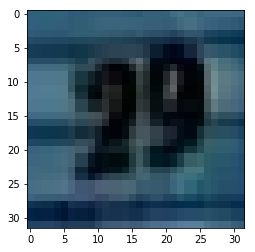

In [35]:
import matplotlib.pyplot as plt
X = X_test[32]
plt.imshow(X)
plt.show()

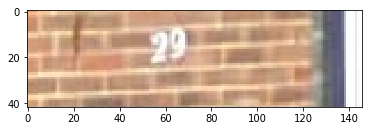

In [36]:
from PIL import Image
Img = Image.open('data/test/33.png')
plt.imshow(Img)
plt.show()

In [27]:

y_pred = model.predict(X.reshape(1,32,32,3))

In [28]:
y_pred

[array([[6.018373e-24, 1.140418e-06, 9.999950e-01, 3.844091e-06]],
       dtype=float32),
 array([[1.02140162e-34, 9.99899387e-01, 5.25800942e-07, 8.42366990e-06,
         8.35054379e-05, 2.23980976e-08, 3.83078714e-06, 3.69597569e-06,
         4.69210335e-07, 1.00354896e-07, 2.15730855e-09]], dtype=float32),
 array([[7.9378259e-34, 8.2009828e-06, 8.9316279e-09, 8.6578467e-07,
         2.2834145e-05, 2.4039326e-04, 9.9240100e-01, 1.3847858e-08,
         4.0341374e-03, 1.4148941e-06, 3.2910726e-03]], dtype=float32),
 array([[8.7453671e-32, 8.1552356e-09, 3.9718440e-10, 9.4166410e-08,
         2.8671692e-11, 3.4552227e-07, 1.8944725e-07, 1.2168323e-10,
         1.7187748e-08, 5.6492890e-09, 9.9999940e-01]], dtype=float32)]

In [29]:
def new_print(y_pred):
    print('预测数字数目 ',np.argmax(y_pred[0],axis=1)[0])
    a=[]
    for i in range(1,4):
        if(np.argmax(y_pred[i],axis=1)[0]==10):
            a.append('')
        else:
            a.append(str(np.argmax(y_pred[i],axis=1)[0]))
    print('预测数字为 ',''.join(a))       
        
new_print(y_pred)

预测数字数目  2
预测数字为  16
